In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Importar Datos

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PROYECTO GRADO/Data_Greener_all.csv")

df.head()


,Time,Ventilation,Sokets plug,Lighting,Other electricity,Cooling,Heating
0,2017-01-03 13:00:00,27.4,41.8,53.7,89.6,18.6,498.0
1,2017-01-03 14:00:00,21.6,37.5,50.9,64.6,61.9,500.0
2,2017-01-03 15:00:00,18.5,37.4,60.1,64.2,16.5,480.0
3,2017-01-03 16:00:00,29.7,38.0,52.6,43.2,19.8,390.0
4,2017-01-03 17:00:00,16.7,38.1,56.7,42.4,15.2,373.0


In [ ]:
# Normalizar variables

# 1. Convertir Time a datetime
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")

# 2. Convertir las demás columnas a numérico
cols_numericas = ["Ventilation", "Sokets plug", "Lighting", "Other electricity", "Cooling", "Heating"]
df[cols_numericas] = df[cols_numericas].apply(pd.to_numeric, errors="coerce")

# Verificar cambios
print(df.dtypes)

Time                 datetime64[ns]
Ventilation                 float64
Sokets plug                 float64
Lighting                    float64
Other electricity           float64
Cooling                     float64
Heating                     float64
dtype: object


In [ ]:
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")

# Crear nuevas columnas
df['hora'] = df["Time"].dt.hour
df["Dia"] = df["Time"].dt.day
df["Mes"] = df["Time"].dt.month
df["Anno"] = df["Time"].dt.year
df["DiaSemanaNum"] = df["Time"].dt.weekday   # 0 = Lunes, 6 = Domingo
df["DiaSemana"] = df["Time"].dt.day_name()   # Nombre del día


df["Total"] = (
    df["Ventilation"]
    + df["Sokets plug"]
    + df["Lighting"]
    + df["Other electricity"]
    + df["Cooling"]
    + df["Heating"]
)

print(df.head())

                 Time  Ventilation  Sokets plug  Lighting  Other electricity  \
0 2017-01-03 13:00:00         27.4         41.8      53.7               89.6   
1 2017-01-03 14:00:00         21.6         37.5      50.9               64.6   
2 2017-01-03 15:00:00         18.5         37.4      60.1               64.2   
3 2017-01-03 16:00:00         29.7         38.0      52.6               43.2   
4 2017-01-03 17:00:00         16.7         38.1      56.7               42.4   

   Cooling  Heating  hora  Dia  Mes  Anno  DiaSemanaNum DiaSemana  Total  
0     18.6    498.0    13    3    1  2017             1   Tuesday  729.1  
1     61.9    500.0    14    3    1  2017             1   Tuesday  736.5  
2     16.5    480.0    15    3    1  2017             1   Tuesday  676.7  
3     19.8    390.0    16    3    1  2017             1   Tuesday  573.3  
4     15.2    373.0    17    3    1  2017             1   Tuesday  542.1  


In [ ]:
# Aseguramos que "Time" sea índice de tiempo
df["Time"] = pd.to_datetime(df["Time"])
df = df.set_index("Time")

df_ori=df.copy()
# Variables a tratar
variables = ["Sokets plug", "Lighting", "Other electricity", "Cooling", "Heating"]

for col in variables:
    # Calcular límites con rango intercuartílico (IQR)
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Reemplazar valores atípicos por NaN
    df.loc[(df[col] < lower) | (df[col] > upper), col] = None

# Interpolación temporal
df[variables] = df[variables].interpolate(method='time')

# (Opcional) Rellenar NaN restantes al inicio o final
df[variables] = df[variables].fillna(method='bfill').fillna(method='ffill')


/tmp/ipython-input-655676188.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[variables] = df[variables].fillna(method='bfill').fillna(method='ffill')


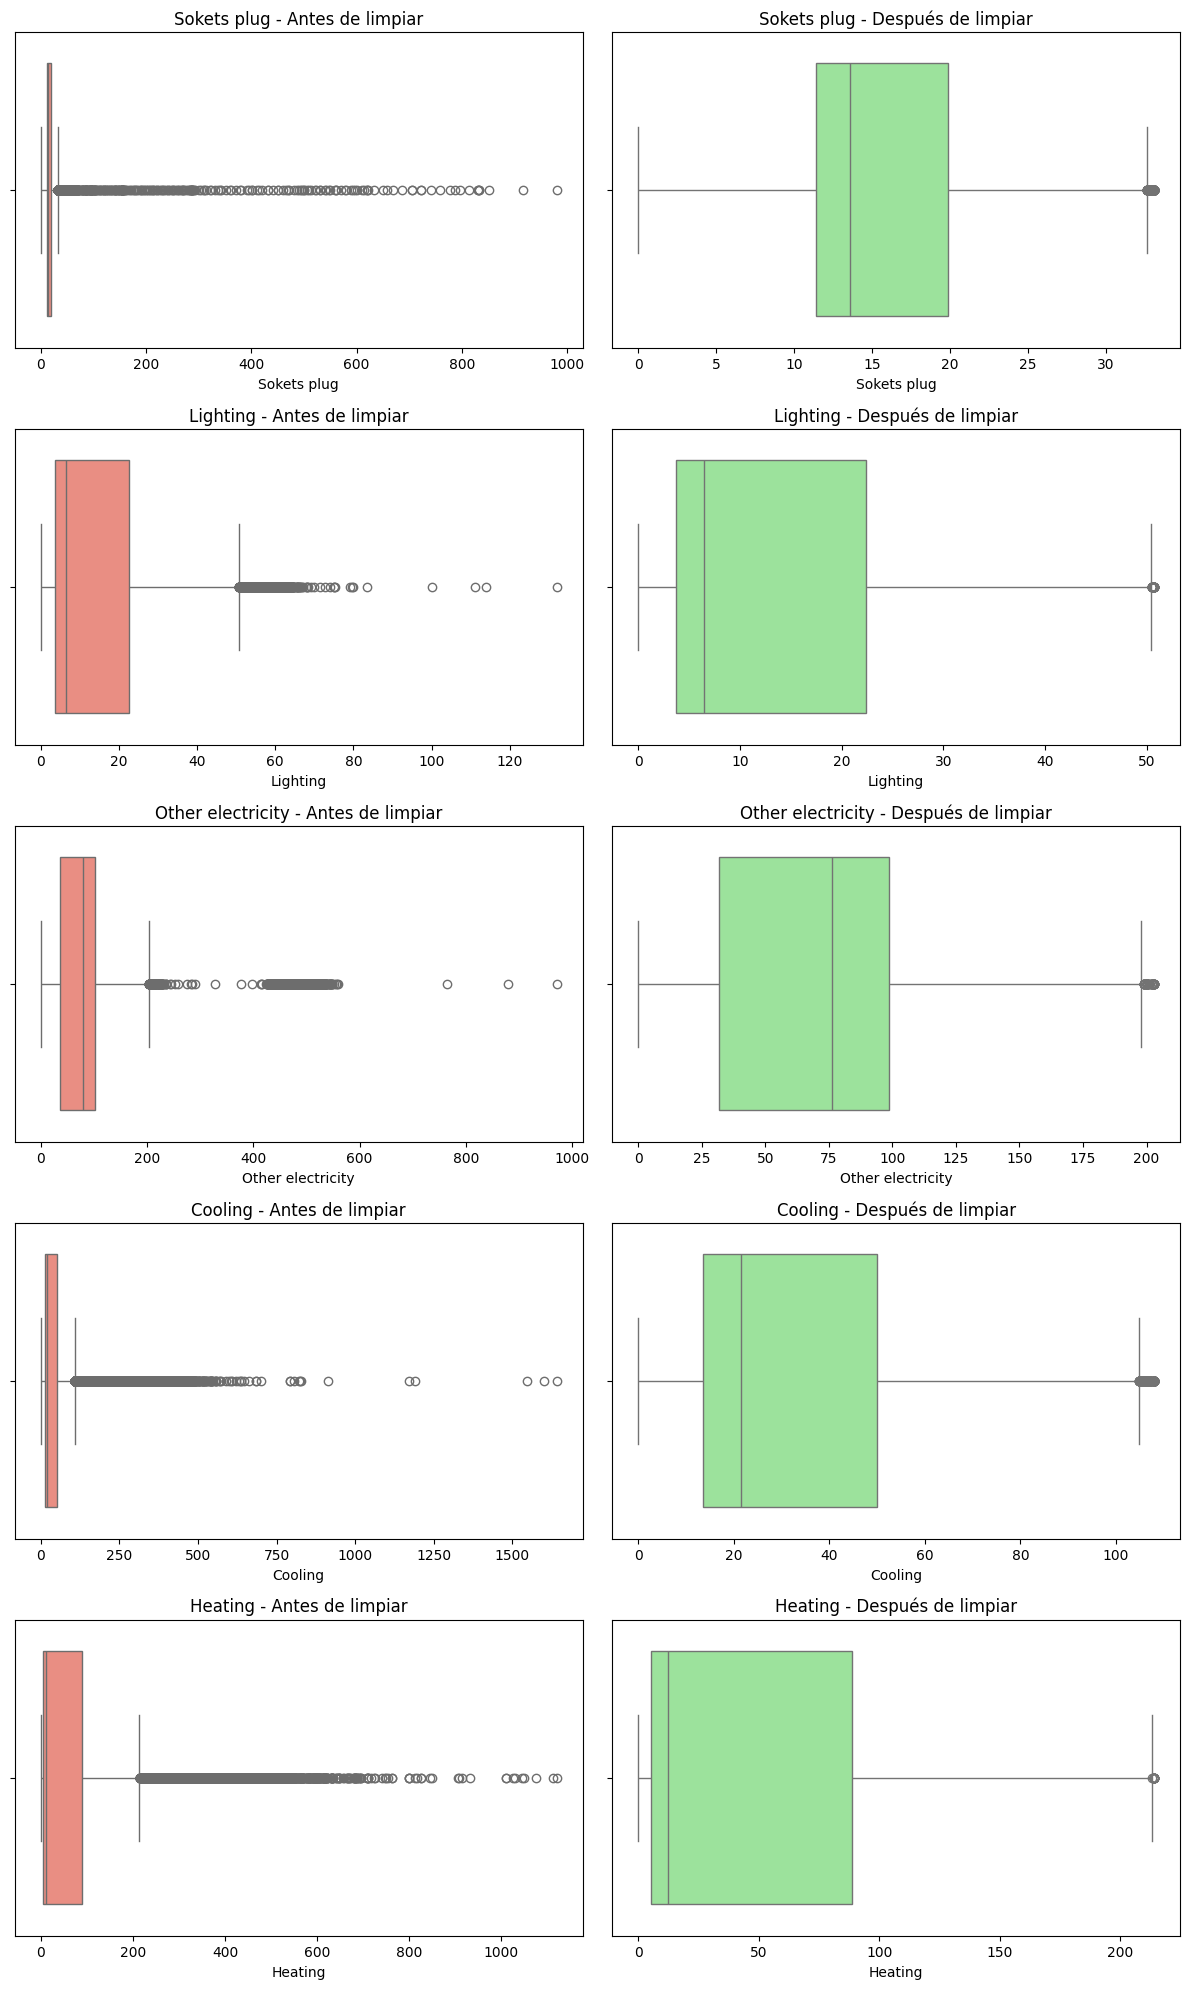

In [ ]:
# Comparación antes vs después
fig, axes = plt.subplots(len(variables), 2, figsize=(12, 4*len(variables)))

for i, col in enumerate(variables):
    # Boxplot antes de limpiar
    sns.boxplot(x=df_ori[col], ax=axes[i, 0], color="salmon")
    axes[i, 0].set_title(f"{col} - Antes de limpiar")

    # Boxplot después de limpiar
    sns.boxplot(x=df[col], ax=axes[i, 1], color="lightgreen")
    axes[i, 1].set_title(f"{col} - Después de limpiar")

plt.tight_layout()
plt.show()

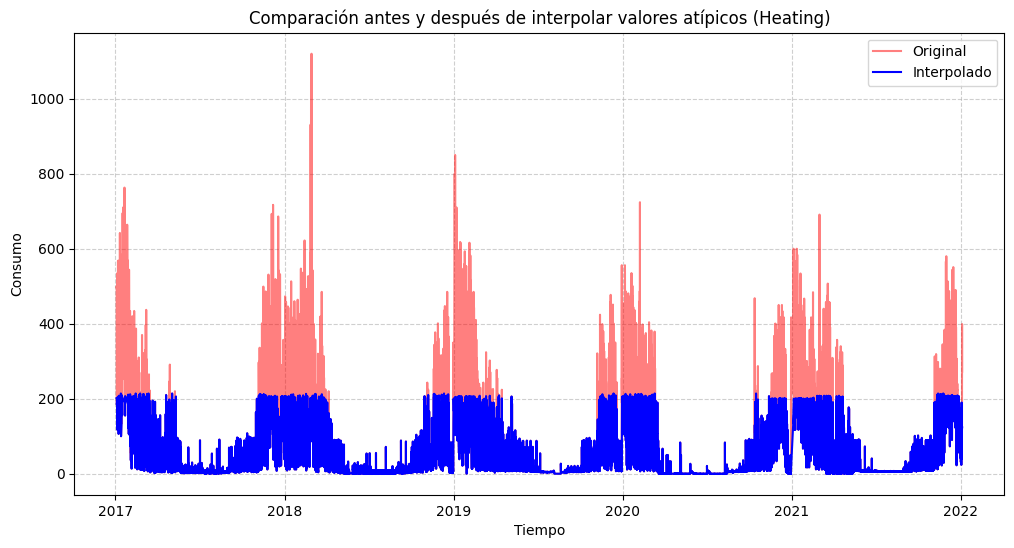

In [ ]:
# --- 4️⃣ Graficar comparación ---
plt.figure(figsize=(12,6))

var = "Heating"
plt.plot(df_ori.index, df_ori[var], label="Original", alpha=0.5, color="red")
plt.plot(df.index, df[var], label="Interpolado", color="blue")
plt.title(f"Comparación antes y después de interpolar valores atípicos ({var})")
plt.xlabel("Tiempo")
plt.ylabel("Consumo")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [ ]:
# Verificamos columnas actuales
print("Columnas del df:")
print(df.columns.tolist())

# Definimos el target para este primer modelo
target = 'Heating'   # luego repetimos para las otras categorías

# Tomamos todas las columnas numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("\nCols numéricas antes de quitar el target:")
print(numeric_cols)

# Quitamos el target de los predictores
numeric_cols = [col for col in numeric_cols if col != target]

print("\nColumnas que usaremos como X (predictoras):")
print(numeric_cols)

# Construimos X e y
X = df[numeric_cols].copy()
y = df[target].copy()

print("\nShapes de X e y:")
print("X:", X.shape)
print("y:", y.shape)

X.head()

Columnas del df:
['Ventilation', 'Sokets plug', 'Lighting', 'Other electricity', 'Cooling', 'Heating', 'hora', 'Dia', 'Mes', 'Anno', 'DiaSemanaNum', 'DiaSemana', 'Total']

Cols numéricas antes de quitar el target:
['Ventilation', 'Sokets plug', 'Lighting', 'Other electricity', 'Cooling', 'Heating', 'Total']

Columnas que usaremos como X (predictoras):
['Ventilation', 'Sokets plug', 'Lighting', 'Other electricity', 'Cooling', 'Total']

Shapes de X e y:
X: (43824, 6)
y: (43824,)


,Ventilation,Sokets plug,Lighting,Other electricity,Cooling,Total
Time,,,,,,
2017-01-03 13:00:00,27.4,27.2,39.5,89.6,18.6,729.1
2017-01-03 14:00:00,21.6,27.2,39.5,64.6,61.9,736.5
2017-01-03 15:00:00,18.5,27.2,39.5,64.2,16.5,676.7
2017-01-03 16:00:00,29.7,27.2,39.5,43.2,19.8,573.3
2017-01-03 17:00:00,16.7,27.2,39.5,42.4,15.2,542.1


Train  Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# División train-test SIN mezclar el orden temporal
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False   # muy importante para series de tiempo
)

print("Tamaño X_train:", X_train.shape)
print("Tamaño X_test :", X_test.shape)
print("Tamaño y_train:", y_train.shape)
print("Tamaño y_test :", y_test.shape)

# Opcional: ver las primeras fechas de cada conjunto si Time está en el índice
print("\nPrimer índice de train:", X_train.index[0], "→ último:", X_train.index[-1])
print("Primer índice de test :", X_test.index[0],  "→ último:", X_test.index[-1])

Tamaño X_train: (35059, 6)
Tamaño X_test : (8765, 6)
Tamaño y_train: (35059,)
Tamaño y_test : (8765,)

Primer índice de train: 2017-01-03 13:00:00 → último: 2021-01-03 07:00:00
Primer índice de test : 2021-01-03 08:00:00 → último: 2022-01-03 12:00:00


XGBoost baseline para Heating

In [ ]:
!pip install -q xgboost

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. Definimos el modelo base de XGBoost para HEATING
xgb_heating = XGBRegressor(
    n_estimators=300,      # número de árboles
    learning_rate=0.05,   # tasa de aprendizaje
    max_depth=6,          # profundidad máxima de cada árbol
    subsample=0.8,        # muestreo de filas
    colsample_bytree=0.8, # muestreo de columnas
    random_state=42,
    n_jobs=-1
)

# 2. Entrenamos el modelo con el conjunto de entrenamiento
xgb_heating.fit(X_train, y_train)

# 3. Hacemos predicciones sobre el conjunto de prueba
y_pred = xgb_heating.predict(X_test)

# 4. Calculamos métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("=== Modelo XGBoost - Heating ===")
print("RMSE:", rmse)
print("MAE :", mae)
print("R2  :", r2)

=== Modelo XGBoost - Heating ===
RMSE: 17.425198291671492
MAE : 10.29644877451274
R2  : 0.940173491794979


Graficamos Y Real - Y Predicción para Healting

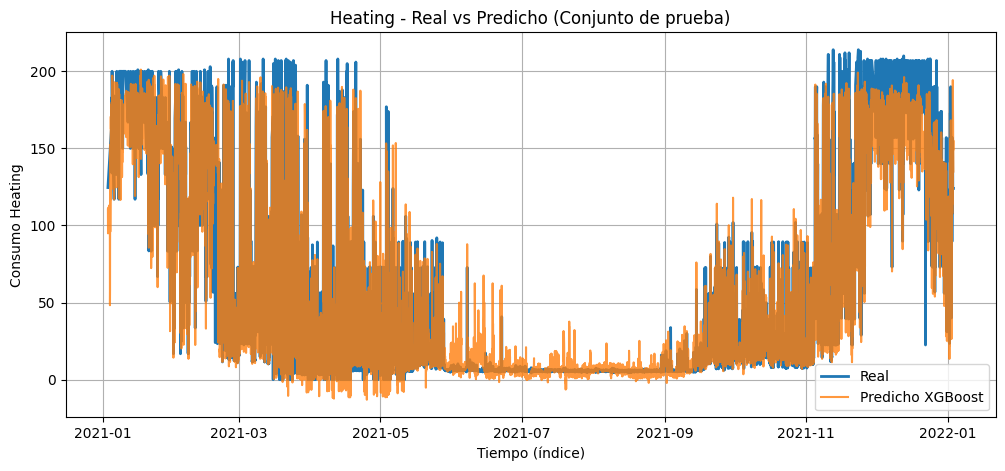

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test.values, label='Real', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicho XGBoost', alpha=0.8)
plt.title('Heating - Real vs Predicho (Conjunto de prueba)')
plt.xlabel('Tiempo (índice)')
plt.ylabel('Consumo Heating')
plt.legend()
plt.grid(True)
plt.show()

Funcion para otras categorias

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def train_xgb_for_target(df, target, test_size=0.2):
    """
    Entrena un XGBRegressor para una variable objetivo (target) dada.
    Usa todas las columnas numéricas excepto el target como predictoras.
    Hace un split 80/20 respetando el orden temporal.
    Devuelve: modelo entrenado, métricas y (y_test, y_pred)
    """
    # 1. Seleccionar columnas numéricas
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != target]

    X = df[numeric_cols].copy()
    y = df[target].copy()

    # 2. Split 80/20 por índice (sin mezclar)
    n = len(df)
    split = int(n * (1 - test_size))

    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]

    # 3. Definir modelo
    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    # 4. Entrenar
    model.fit(X_train, y_train)

    # 5. Predecir y métricas
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    metrics = {
        'target': target,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

    return model, metrics, y_test, y_pred

Entrenamiento de un modelo por cada categoría

In [ ]:
import pandas as pd

targets = ['Ventilation', 'Sokets plug', 'Lighting', 'Other electricity', 'Cooling', 'Heating']

models = {}
metrics_list = []

for t in targets:
    print(f"\n=== Entrenando modelo XGBoost para: {t} ===")
    model_t, metrics_t, y_test_t, y_pred_t = train_xgb_for_target(df, t)

    models[t] = {
        'model': model_t,
        'y_test': y_test_t,
        'y_pred': y_pred_t
    }
    metrics_list.append(metrics_t)

    print("RMSE:", metrics_t['rmse'])
    print("MAE :", metrics_t['mae'])
    print("R2  :", metrics_t['r2'])

# Resumen en tabla
metrics_df = pd.DataFrame(metrics_list)
display(metrics_df)


=== Entrenando modelo XGBoost para: Ventilation ===
RMSE: 25.68732209091785
MAE : 13.15519060819299
R2  : 0.5671808333744581

=== Entrenando modelo XGBoost para: Sokets plug ===
RMSE: 3.9173040883196264
MAE : 2.7229055173538708
R2  : 0.6638397533439298

=== Entrenando modelo XGBoost para: Lighting ===
RMSE: 5.214825398851691
MAE : 3.693501596930744
R2  : 0.8266384067411402

=== Entrenando modelo XGBoost para: Other electricity ===
RMSE: 24.57559901550271
MAE : 15.092419671311951
R2  : 0.546988883501734

=== Entrenando modelo XGBoost para: Cooling ===
RMSE: 9.472649302774764
MAE : 7.111979635720694
R2  : 0.8000004121367296

=== Entrenando modelo XGBoost para: Heating ===
RMSE: 17.425198291671492
MAE : 10.29644877451274
R2  : 0.940173491794979


,target,rmse,mae,r2
0,Ventilation,25.687322,13.155191,0.567181
1,Sokets plug,3.917304,2.722906,0.663840
2,Lighting,5.214825,3.693502,0.826638
3,Other electricity,24.575599,15.092420,0.546989
4,Cooling,9.472649,7.111980,0.800000
5,Heating,17.425198,10.296449,0.940173


**Graficas por categorias**


=== Ventilation ===


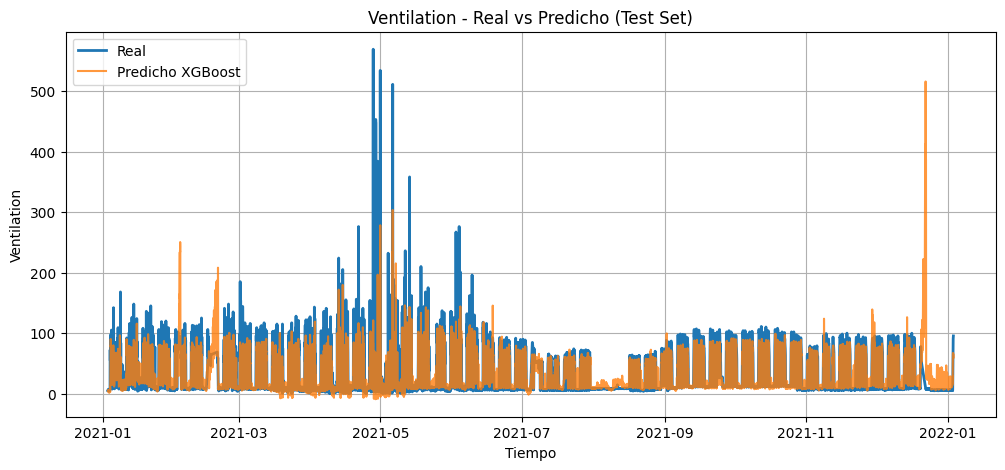


=== Sokets plug ===


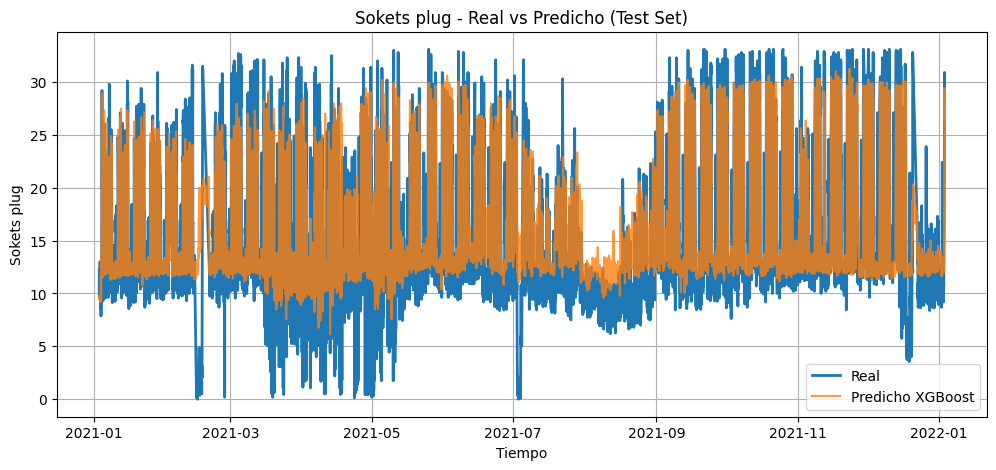


=== Lighting ===


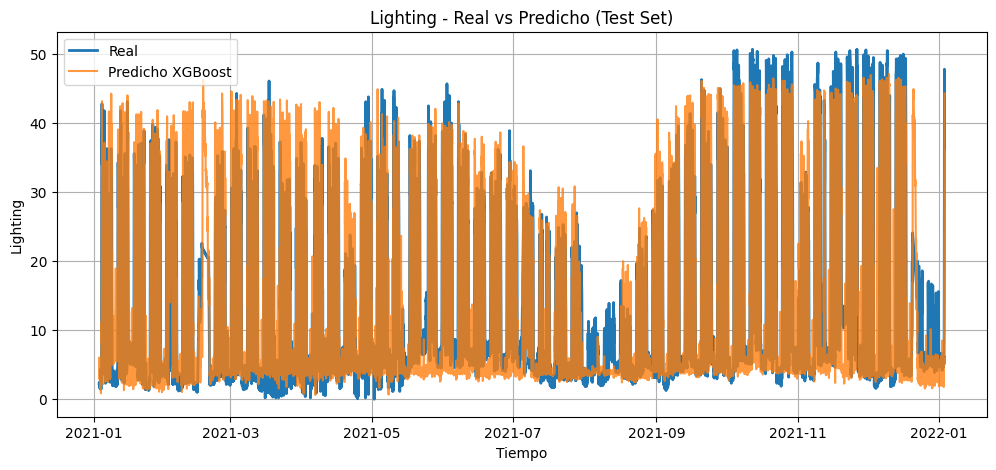


=== Other electricity ===


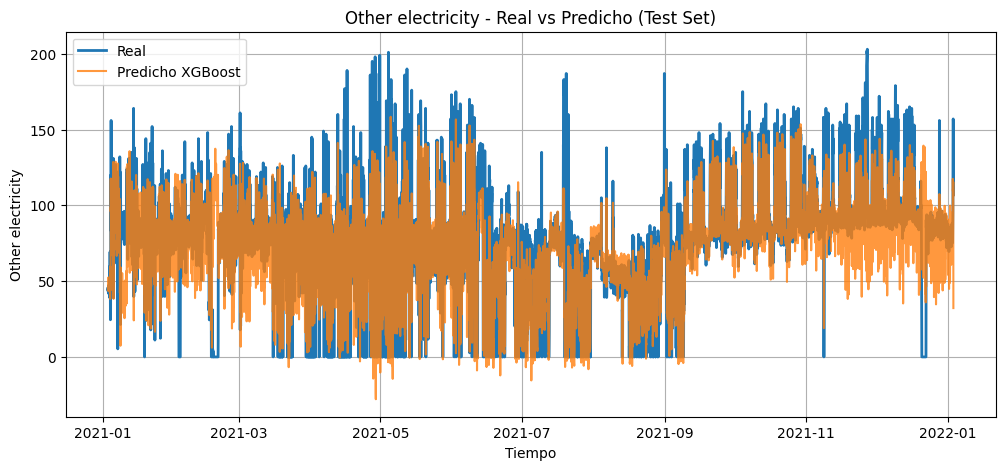


=== Cooling ===


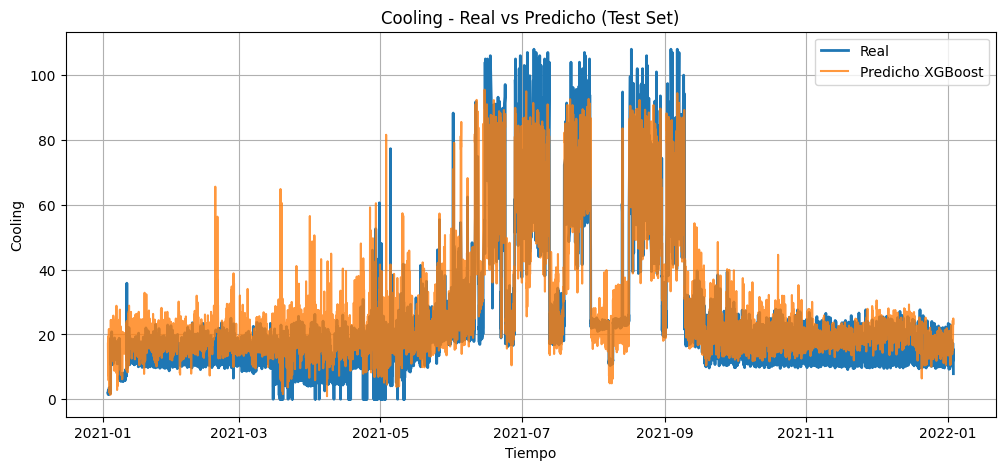


=== Heating ===


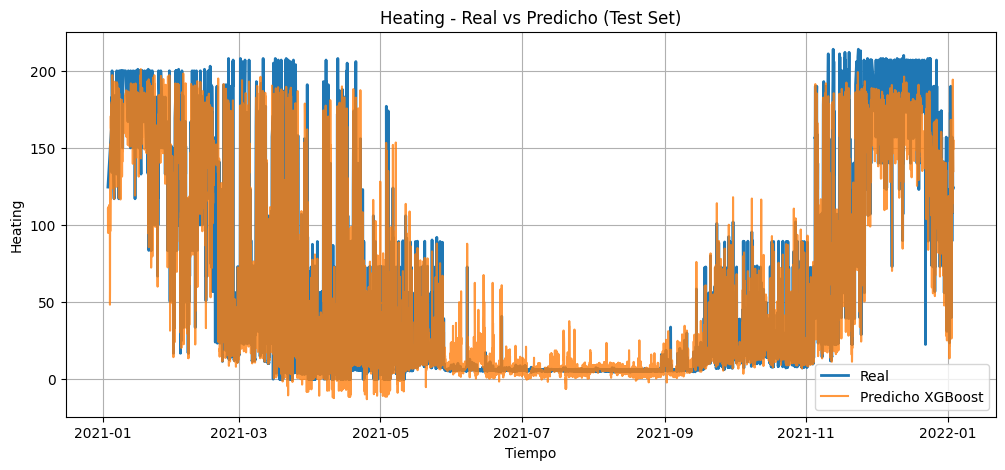

In [ ]:
import matplotlib.pyplot as plt

def plot_real_vs_pred(target, models_dict):
    """
    Grafica Real vs Predicho para un target usando el diccionario 'models'
    que ya generamos en el loop anterior.
    """
    y_test = models_dict[target]['y_test']
    y_pred = models_dict[target]['y_pred']

    plt.figure(figsize=(12,5))
    plt.plot(y_test.index, y_test.values, label='Real', linewidth=2)
    plt.plot(y_test.index, y_pred, label='Predicho XGBoost', alpha=0.8)
    plt.title(f'{target} - Real vs Predicho (Test Set)')
    plt.xlabel('Tiempo')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.show()

# Ejecutar para las 6 categorías
for t in targets:
    print(f"\n=== {t} ===")
    plot_real_vs_pred(t, models)

Error absoluto para cada categoria - MAE en el tiempo


=== Error Absoluto: Ventilation ===


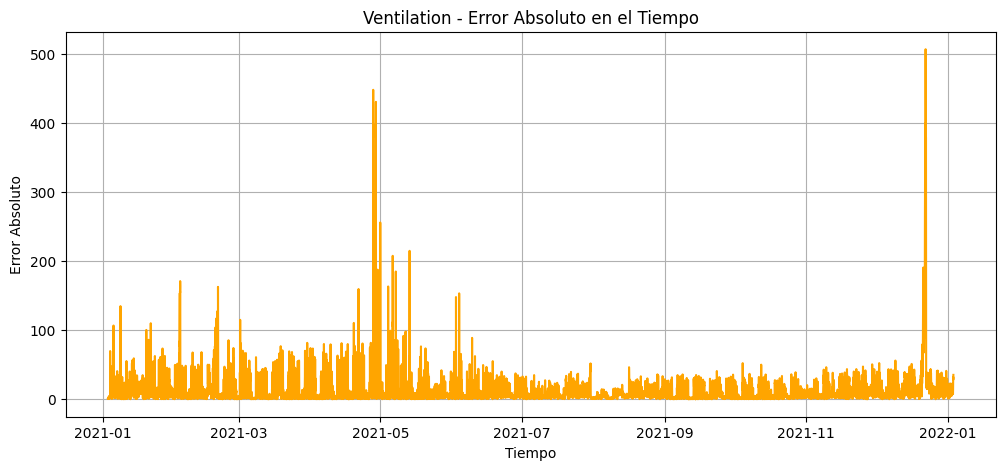


=== Error Absoluto: Sokets plug ===


In [ ]:
def plot_absolute_error(target, models_dict):
    y_test = models_dict[target]['y_test']
    y_pred = models_dict[target]['y_pred']

    abs_error = abs(y_test.values - y_pred)

    plt.figure(figsize=(12,5))
    plt.plot(y_test.index, abs_error, color='orange')
    plt.title(f'{target} - Error Absoluto en el Tiempo')
    plt.xlabel('Tiempo')
    plt.ylabel('Error Absoluto')
    plt.grid(True)
    plt.show()

# Ejecutar para todas
for t in targets:
    print(f"\n=== Error Absoluto: {t} ===")
    plot_absolute_error(t, models)

**Feature Importance**


=== Importance Variables: Ventilation ===


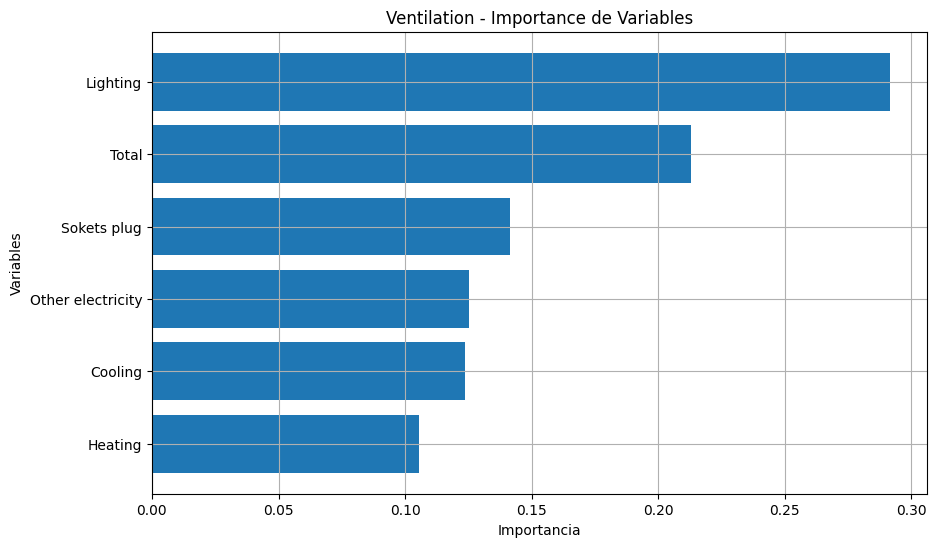


=== Importance Variables: Sokets plug ===


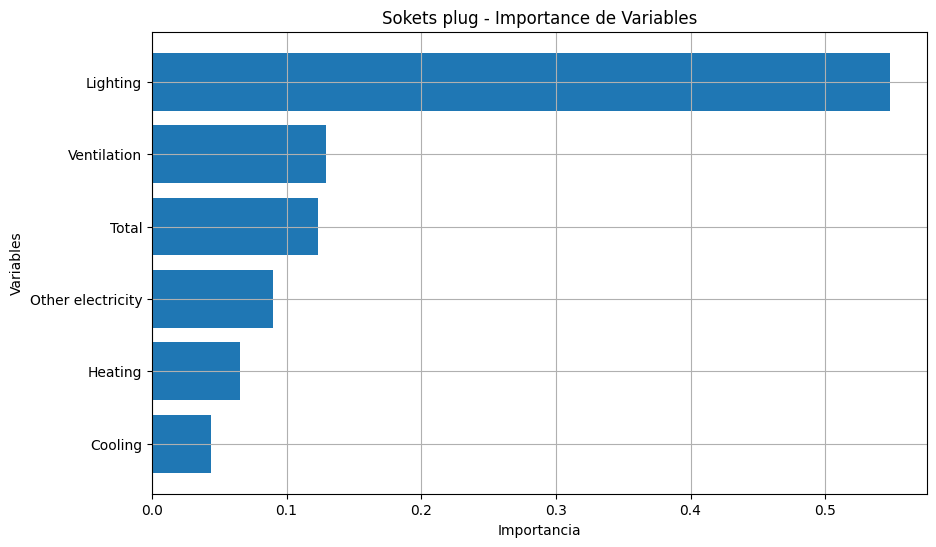


=== Importance Variables: Lighting ===


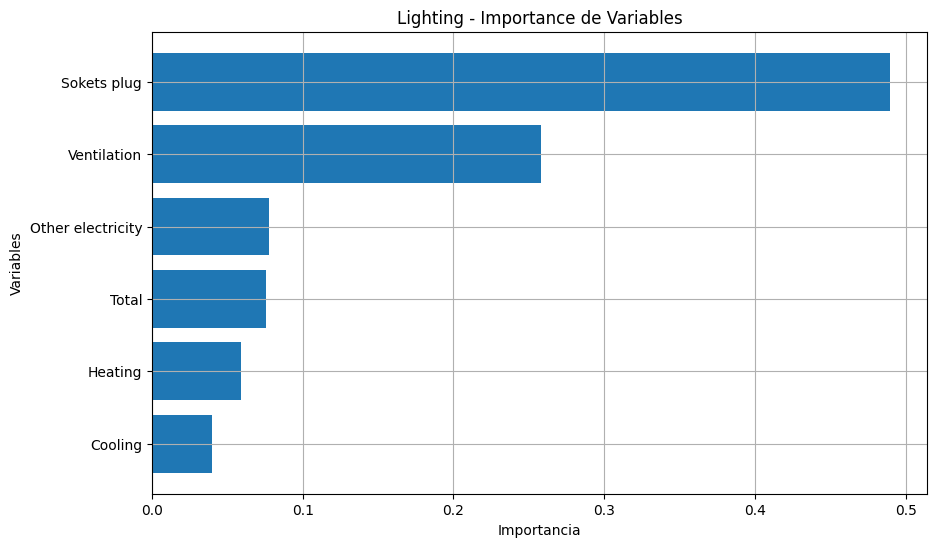


=== Importance Variables: Other electricity ===


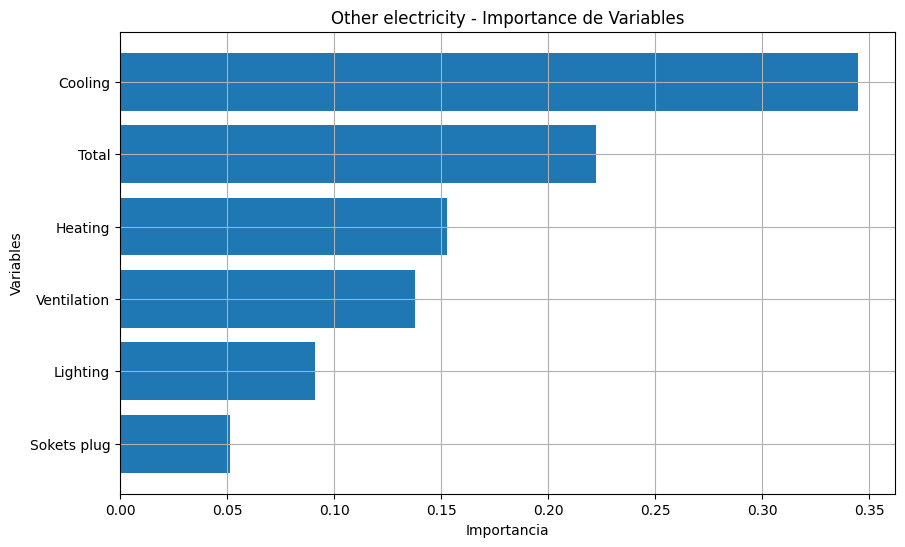


=== Importance Variables: Cooling ===


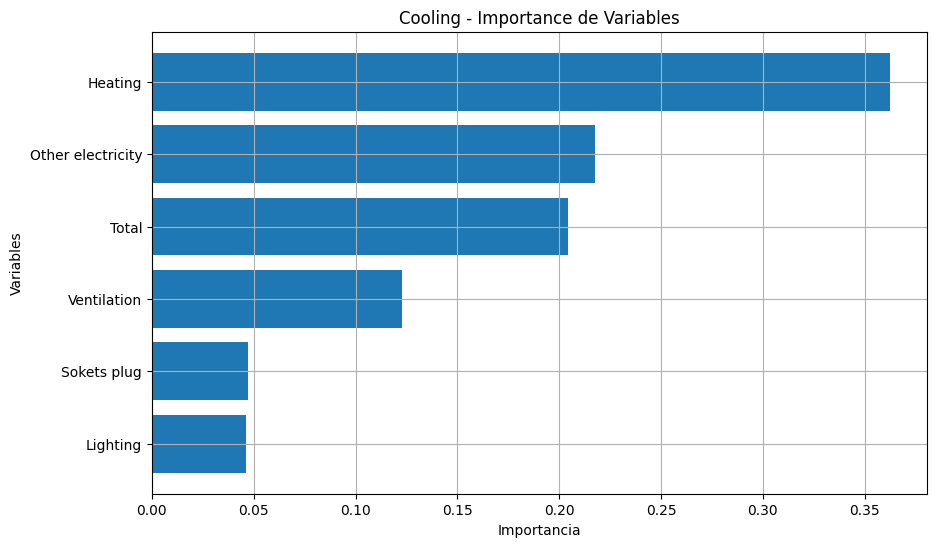


=== Importance Variables: Heating ===


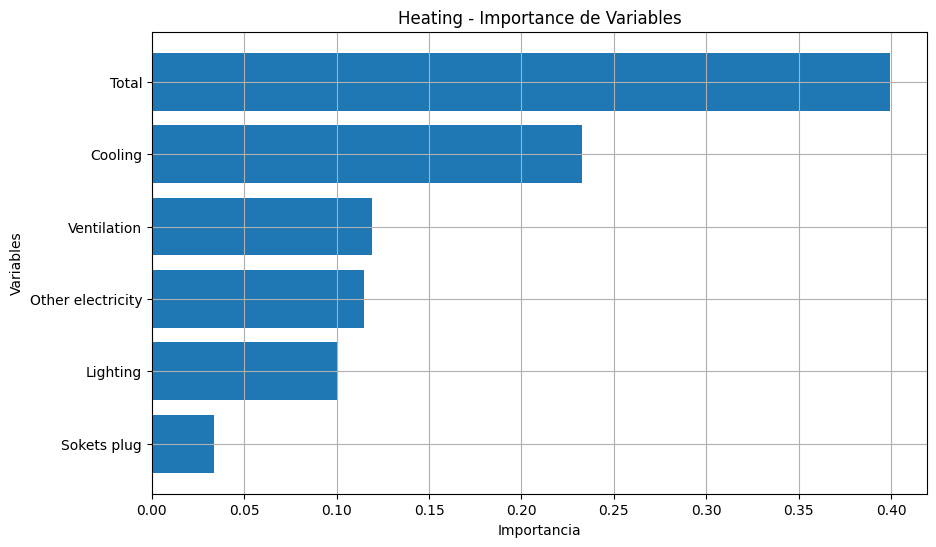

In [ ]:
import numpy as np

def plot_feature_importance(target, df, models_dict):
    model = models_dict[target]['model']

    # tomamos solo columnas numéricas excepto el target
    num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
    num_cols = [c for c in num_cols if c != target]

    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]

    plt.figure(figsize=(10,6))
    plt.barh([num_cols[i] for i in indices], importance[indices])
    plt.title(f'{target} - Importance de Variables')
    plt.xlabel('Importancia')
    plt.ylabel('Variables')
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.show()

# Ejecutar para todas las categorías
for t in targets:
    print(f"\n=== Importance Variables: {t} ===")
    plot_feature_importance(t, df, models)

Desempeño de XGBoost por categoría energética

El modelo XGBoost mostró un comportamiento consistente y adecuado para la desagregación del consumo eléctrico por categorías. Los mejores desempeños se observan en Heating, Lighting y Cooling, con valores de R² de 0.94, 0.83 y 0.80, respectivamente, indicando una excelente capacidad del modelo para capturar las variaciones temporales y de magnitud en estas variables.

En contraste, las categorías Ventilation y Other electricity presentaron desempeños moderados, con R² entre 0.54 y 0.57, lo cual sugiere que estas categorías pueden depender de factores externos no presentes en los datos o tener un comportamiento más errático. No obstante, el modelo sigue logrando una aproximación funcional para propósitos operativos y de análisis energético.